# Sentiment Analysis of Twitter Feeds to Find Your Favorite Airline

Process the raw data and created a final Pandas DataFrame to pass to the Spark application -

In [1]:
import json
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#create a file to contain the 'raw data' from the twitter streaming api
raw_data_path = '../tweets_all@#_80017.json'

#create a list to hold the tweets
raw_data = []

#create and open the new file
tweets_file = open(raw_data_path, "r")

#append to the tweets list from the raw data file
for line in tweets_file:
    try:
        tweet = json.loads(line)
        raw_data.append(tweet)
    except:
        continue       
print "Number of raw data rows - ", len(raw_data)

Number of raw data rows -  80017


In [3]:
tweets = pd.DataFrame()

In [4]:
#removed u'possibly_sensitive', at the moment since not all rows have it
#it goes between place and retweet_count in the below list
twitter_fields = [u'contributors', u'coordinates', u'created_at', u'entities', 
                  u'favorite_count', u'favorited', u'filter_level', u'geo', u'id',
                  u'id_str', u'in_reply_to_screen_name', u'in_reply_to_status_id', 
                  u'in_reply_to_status_id_str', u'in_reply_to_user_id', u'in_reply_to_user_id_str', 
                  u'lang', u'place',   u'retweet_count', u'retweeted', u'source', 
                  u'text', u'timestamp_ms', u'truncated', u'user']

#set the columns in the dataframe to match the json fields of the twitter streaming api
for t in twitter_fields:
    tweets[t] = map(lambda tweet: tweet[t] if tweet[t] else 'None', raw_data)
tweets['followers_count'] = map(lambda tweet: tweet['user']['followers_count'] if tweet['user'] != None else None, raw_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, raw_data)

In [5]:
#View the first 5 tweets of the dataset
pd.set_option('max_colwidth', 200)
tweets['text'].head(5)

0                      #United States Football Tickets News https://t.co/82wIUcjYt6 https://t.co/cyGk7msfUQ
1    In fact I have rarely in my entire life (if ever?) felt more bamboozled by an airline. @SpiritAirlines
2                      #United States Football Tickets News https://t.co/USYm8mOueG https://t.co/35eZEfycvB
3                      #United States Football Tickets News https://t.co/SFVIa6D9dg https://t.co/owpvznBCrA
4                                       Complimentary #Citrix CTP WiFi on @Delta flight, always a pleasure!
Name: text, dtype: object

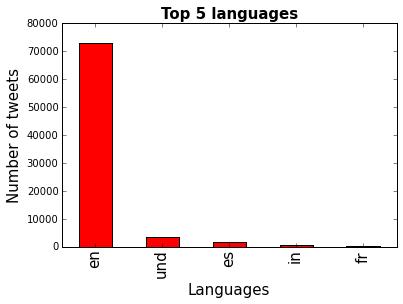

In [6]:
#view the top 5 languages present in the dataset
tweets_by_lang = tweets['lang'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')

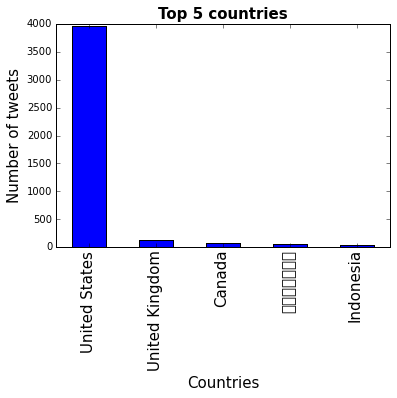

In [7]:
#view the top 5 countries in the dataset
tweets_by_country = tweets['country'].value_counts()
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue')

In [8]:
import re
#create a function to find the word in the tweet text field
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    return False

In [9]:
#get the words in the text
airlines = ['southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir']

#create columns for each airline and set a boolean value to use for the below visualization of tweet count 
#for each airline
for a in airlines:
    if (tweets['text'].apply(lambda tweet: word_in_text(a, tweet))).count() > 0:
        tweets[a] = tweets['text'].apply(lambda tweet: word_in_text(a, tweet))

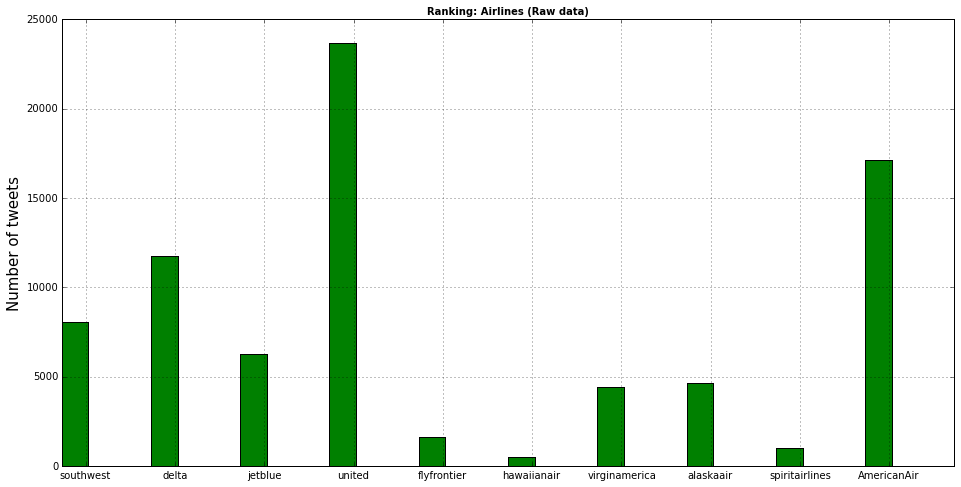

In [10]:
#view the amount of tweets per airline
tweets_by_airlines = [len(tweets.loc[tweets['southwest'] == True]), 
 len(tweets.loc[tweets['delta'] == True]), len(tweets.loc[tweets['jetblue'] == True]),
         len(tweets.loc[tweets['united'] == True]), len(tweets.loc[tweets['flyfrontier'] == True]),
                     len(tweets.loc[tweets['hawaiianair'] == True]),len(tweets.loc[tweets['virginamerica'] == True]),
                     len(tweets.loc[tweets['alaskaair'] == True]),len(tweets.loc[tweets['spiritairlines'] == True]),
                     len(tweets.loc[tweets['AmericanAir'] == True])]

airlines = ['southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir']

x_pos = list(range(len(airlines)))
width = 0.3
fig, ax = plt.subplots(figsize=(16,8))
plt.bar(x_pos, tweets_by_airlines, width, alpha=1, color='g')
# Setting axis labels and ticks
ax.set_ylabel('Number of tweets', fontsize=15)
ax.set_title('Ranking: Airlines (Raw data)', fontsize=10, fontweight='bold')
ax.set_xticks([p + 0.9 * width for p in x_pos])
ax.set_xticklabels(airlines)
plt.grid()

In [11]:
#create a dataframe called 'processed_data' with extra column 'airline'

#a function to set the airline name where the column value is True
def setAirlineName(row):   
    x = None
    for a in airlines:
        if row[a] is True:
            x = a
    if x is not None:
        return x
    else: 
        return

# set a column in the tweets dataframe for each airline name with a boolean value
for a in airlines:
    if (tweets['text'].apply(lambda tweet: word_in_text(a, tweet))).count() > 0:
        tweets[a] = tweets['text'].apply(lambda tweet: word_in_text(a, tweet))

#add the airline column with the airline name as the value 
tweets['airline'] = tweets.apply(lambda row: setAirlineName(row), axis=1)  

#remove the temp. columns for each airline
for a in airlines:
    tweets = tweets.drop(a, 1)

#set the final variable to be passed to the spark process
processed_data = tweets

#processed_data['airline'] values are - 'southwest', 'delta', 'jetblue', 'united', 'flyfrontier', 
# 'hawaiianair', 'virginamerica', 'alaskaair','spiritairlines', 'AmericanAir'
print 'The Processed Data File contains', len(processed_data), 'tweets.'

The Processed Data File contains 80017 tweets.


In [12]:
#create a json file from the processed_data pandas dataframe
#it has the extra airline field that will be used for spark processing

#This is commented out since we are using the processed_data dataframe for the spark processing
# with open('processed_data.json', 'w') as outfile:  
#     for index, row in processed_data.iterrows():
#         outfile.write(row.to_json())
#         outfile.write('\n')

# Pass the data with airlines to Spark for text processing

In [12]:
from pattern.en import parse
from pattern.en import pprint
from pattern.vector import stem, PORTER, LEMMA
from sklearn.feature_extraction import text
from gensim import corpora 

In [13]:
import findspark
findspark.init()
print findspark.find()

/usr/local/opt/apache-spark/libexec


In [14]:
import pyspark

In [15]:
# adapted from HW5
def get_parts(thetext, punc='.,;:!?()[]{}`''\"@#$^&*+-|=~_'):
    # generate stopwords list & regexes for 2+ periods or 2+ dashes
    stop = text.ENGLISH_STOP_WORDS
    regex1=re.compile(r"\.{2,}")
    regex2=re.compile(r"\-{2,}")
    thetext=re.sub(regex1, ' ', thetext)
    thetext=re.sub(regex2, ' ', thetext)
    punctuation = list(punc)
    nouns=[]
    descriptives=[]
    for i,sentence in enumerate(parse(thetext, tokenize=True, lemmata=True).split()):
        nouns.append([])
        descriptives.append([])
        for token in sentence:
            if len(token[4]) >0:
                if token[1] in ['JJ', 'JJR', 'JJS']:
                    if token[4] in stop or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    descriptives[i].append(token[4])
                elif token[1] in ['NN', 'NNS']:
                    if token[4] in stop or token[4][0] in punctuation or token[4][-1] in punctuation or len(token[4])==1:
                        continue
                    nouns[i].append(token[4])
    out=zip(nouns, descriptives)
    nouns2=[]
    descriptives2=[]
    for n,d in out:
        if len(n)!=0 and len(d)!=0:
            nouns2.append(n)
            descriptives2.append(d)
    return nouns2, descriptives2

In [16]:
# initialize Spark context
conf = pyspark.SparkConf().setAppName("Twitter_Airline").setMaster("local[*]")
sc = pyspark.SparkContext(conf=conf)

In [17]:
# get tweets from text file
#text_lines = sc.textFile('tweets_all@#_7591.json')
#tweets = text_lines.map(json.loads)
#tweets_text = tweets.map(lambda t: t['text'])

# read tweets & associated airlines into Spark
tweets_text = sc.parallelize([(row['airline'], row['text']) for index, row in processed_data.iterrows()])

### Sentiment of a sentence based on log probs in a word list

Function to read the word list file:

In [18]:
import numpy as np
# read the word list
def readSentimentList(file_name):
    ifile = open(file_name, 'r')
    happy_log_probs = {}
    sad_log_probs = {}
    ifile.readline() #Ignore title row
    # splitting the csv
    for line in ifile:
        tokens = line[:-1].split(',')
        happy_log_probs[tokens[0]] = float(tokens[1])
        sad_log_probs[tokens[0]] = float(tokens[2])

    return happy_log_probs, sad_log_probs

Using Naive Bayes rule:

In [19]:
def classifySentiment(words, happy_log_probs, sad_log_probs):
    # get the log-probability of each word under each sentiment
    happy_probs = [happy_log_probs[word] for word in words if word in happy_log_probs]
    sad_probs = [sad_log_probs[word] for word in words if word in sad_log_probs]

    # sum all the log-probabilities for each sentiment to get a log-probability for the whole tweet
    tweet_happy_log_prob = np.sum(happy_probs)
    tweet_sad_log_prob = np.sum(sad_probs)

    # calculate the probability of the tweet belonging to each sentiment
    prob_happy = np.reciprocal(np.exp(tweet_sad_log_prob - tweet_happy_log_prob) + 1)
    prob_sad = 1 - prob_happy

    return prob_happy, prob_sad

Load the word list:

In [20]:
# load list of words and log probs
happy_log_probs, sad_log_probs = readSentimentList('wordlist.csv')

Reading in the tweet:

In [21]:
# read tweet
tweet1 = ['my', 'hate', 'southwest']

# calculate the probability
tweet1_happy_prob, tweet1_sad_prob = classifySentiment(tweet1, happy_log_probs, sad_log_probs)

print tweet1 
print "happy probability: " , tweet1_happy_prob 
print "sad probability:", tweet1_sad_prob

['my', 'hate', 'southwest']
happy probability:  0.280105168408
sad probability: 0.719894831592


In [22]:
# get words out for sentiment analysis
puncs = '.,;:!?()[]{}`''\"@#$^&*+-|=~_'
sentiment_words = tweets_text.mapValues(lambda t: t.strip(puncs).split())

# classify sentiment of tweet
tweets_probs = sentiment_words.mapValues(lambda ws: classifySentiment(ws, happy_log_probs, sad_log_probs))
happy_probs = tweets_probs.mapValues(lambda (hprob, sprob): (hprob, 1))
sad_probs = tweets_probs.mapValues(lambda (hprob, sprob): (sprob, 1))


Create an output.csv file to use for visualization 

In [23]:
#collect the happy probabilities from the above mapValues call
listOfHappyProbs = happy_probs.collect()

#create an empty list to contain the just the probability portion of happy_probs
HappyProbsList = []
for x in range(len(listOfHappyProbs)):
    HappyProbsList.append(listOfHappyProbs[x][1][0])

#create the following dataframe containing columns of data for visualization
# text, airline, positive, prob, created_at, favorite_count, retweet_count, followers_count
df_data_visualization = pd.DataFrame()
df_data_visualization['created_at'] = processed_data['created_at']
df_data_visualization['favorite_count'] = processed_data['favorite_count']
df_data_visualization['retweet_count'] = processed_data['retweet_count']
df_data_visualization['followers_count'] = processed_data['followers_count']
# df_data_visualization['text'] = processed_data['text']
df_data_visualization['airline'] = processed_data['airline']
df_data_visualization['prob'] = HappyProbsList

#a function to set a 1 if the happy probability is greater than .5 otherwise set it to 0
#we will use this for the visualization aspect
def setPositiveValues(row):
    if row['prob'] > 0.5:
        return 1
    else:
        return 0

#run the function on the prob column to create the positive column to determine if a tweet is positive or negative
#from the happy probability
df_data_visualization['positive'] = df_data_visualization.apply(setPositiveValues, axis=1)

#create the text column, remove the newlines from the text to resolve an issue with row creation in the .to_csv call
df_data_visualization['text'] = processed_data['text'].str.replace('\n',"")

#create a .csv file to use for visualization 
df_data_visualization.to_csv('output.csv', encoding='utf-8', index=False)

## Visualization

reading hte output file

In [24]:
df = pd.read_csv("output.csv")
#df.to_csv("output.csv", date_format='%Y%m%d')
#getting rid of undecided tweets
df = df[(df.prob <> .5)]
df.head()

,created_at,favorite_count,retweet_count,followers_count,airline,prob,positive,text
1,Mon Nov 30 12:59:18 +0000 2015,None,None,2234,spiritairlines,0.959401,1,In fact I have rarely in my entire life (if ever?) felt more bamboozled by an airline. @SpiritAirlines
4,Mon Nov 30 12:59:49 +0000 2015,None,None,1672,delta,0.987388,1,"Complimentary #Citrix CTP WiFi on @Delta flight, always a pleasure!"
5,Mon Nov 30 13:00:02 +0000 2015,None,None,189,AmericanAir,0.873072,1,@judsonabts @AmericanAir the thing about it is they were my carry ons...
10,Mon Nov 30 13:00:37 +0000 2015,None,None,16720,virginamerica,0.797083,1,.@United responds to @VirginAmerica entering #Denver - San Francisco market https://t.co/P47FlIPWXy https://t.co/et2OeZSZCe
11,Mon Nov 30 13:00:40 +0000 2015,None,None,16,AmericanAir,0.955934,1,@AmericanAir another flight with American and again a super cramped seat. It's not an airplane it's a Sardine Can it seems like it.


Running Plotly

In [25]:
#run these using your username and key
import plotly.tools as tls
tls.set_credentials_file(username='ayinmv', api_key='rq66z3hqx8')

import plotly.plotly as py
from plotly.graph_objs import *

#install cufflink package
import cufflinks as cf
print cf.__version__

0.7.1


Number of Tweets

In [26]:
airline_count = df.groupby(['airline']).count().prob.sort_values(axis=0, ascending=False, inplace=False)
airline_count.iplot(kind='bar', yTitle='Number of Tweets', title='Number of Tweets')

tls.embed('https://plot.ly/~ayinmv/33')

Score of the airlines based on the average of their positive scores

In [27]:
airline_count = df.groupby(['airline']).mean().prob.sort_values(axis=0, ascending=False, inplace=False)
airline_count.iplot(kind='bar', yTitle='Average Score', title='Average Score')

tls.embed('https://plot.ly/~ayinmv/63')

Most important tweets

In [28]:
pd.set_option('max_colwidth', 200)

df.sort_values(by=['followers_count'], ascending=[False])[['followers_count','text', 'prob', 'created_at']].head(20)

,followers_count,text,prob,created_at
65626,9561279,@beauflynn @VirginAmerica Yea baby! Fav airline to fly outta FLL. Safe travels bro great seeing you,0.999871,Sun Nov 29 02:58:52 +0000 2015
28748,4546595,A couple teammates took in a different form of elite training during the off-day in Atlanta at @Delta​ HQ: https://t.co/pDpWK0aeKc,0.993440,Thu Dec 03 23:39:13 +0000 2015
32989,3313970,@AmericanAir thank you for the concierge key this year! hope i get renewed for 2016!,0.998328,Fri Dec 04 08:55:41 +0000 2015
32946,3313940,me &amp; @R3HAB waited until our row fell asleep then made a lil banger here on @americanair studios.,0.960900,Fri Dec 04 08:46:26 +0000 2015
29956,3068510,Had the best time spreading cheer today @delta's Holiday in the Hangar event! Check out this winter wonderland! #DeltaLAX #DeltaGreaterGood,0.997183,Fri Dec 04 01:39:24 +0000 2015
69840,2042736,"Apparently "" sully "" the service dog who weighs at least 50 pounds is having trouble getting comfortable in business class @Delta",0.998998,Sun Nov 29 16:43:22 +0000 2015
37489,1974275,@alyswonderland_ @united @Delta @AlaskaAir @AmericanAir @SouthwestAir @BoeingAirplanes We have a 13th row onboard! 🌙🔮✨,0.711730,Fri Dec 04 20:10:24 +0000 2015
28462,1974196,"@FateWillTell @AmericanAir @Delta @FlyFrontier @LaGuardiaAir Sorry, forgot to mention FLL is the closest we've got!",0.904682,Thu Dec 03 22:15:29 +0000 2015
28320,1974194,@FateWillTell @AmericanAir @Delta @FlyFrontier @LaGuardiaAir Trying to get to Miami from LGA?,0.688497,Thu Dec 03 22:01:29 +0000 2015
28351,1974194,"@FateWillTell @AmericanAir @Delta @FlyFrontier @LaGuardiaAir Sorry to hear this! So you don't have a booking with us, correct?",0.975038,Thu Dec 03 22:04:21 +0000 2015


Pulling groupby airline output

In [29]:
dfgroupby = pd.read_csv("outputgroupby.csv")
dfgroupby.head()

,alaskaair,AmericanAir,delta,flyfrontier,hawaiianair,jetblue,southwest,spiritairlines,united,virginamerica
0,0.993208,0.873072,0.987388,0.997226,0.931447,0.952768,0.996007,0.959401,0.886928,0.797083
1,0.965431,0.955934,0.830840,0.998100,0.805865,0.959188,0.591763,0.753549,0.999895,0.797083
2,0.712421,0.926986,0.729272,0.976348,0.374371,0.801286,0.966923,0.989527,0.998912,0.921270
3,0.758827,0.878757,0.986554,0.967824,0.712421,0.958959,0.957541,0.874128,0.992084,0.597163
4,0.996239,0.953406,0.986554,0.954536,0.798882,0.984909,0.872952,0.962676,0.999378,0.597163


Quantile plot

In [30]:
dfgroupby.iplot(kind='box', title='Score Quantiles')

tls.embed('https://plot.ly/~ayinmv/78')

We can aggregate all the happy & sad probabilities for individual tweets about each airline into an average probability that users are happy or sad about that airline:

In [31]:
airline_happy_probs = happy_probs.reduceByKey(lambda (p1,num1),(p2,num2): ((num1*p1 + num2*p2)/(num1 + num2), num1 + num2)).mapValues(lambda (p, n): p) 
airline_sad_probs = sad_probs.reduceByKey(lambda (p1,num1),(p2,num2): ((num1*p1 + num2*p2)/(num1 + num2), num1 + num2)).mapValues(lambda (p, n): p) 
print "Happy probabilities:", airline_happy_probs.take(5)
print "Sad probabilities:", airline_sad_probs.take(5)

Happy probabilities: [('alaskaair', 0.83815078508171414), (None, 0.71349350361302999), ('hawaiianair', 0.82037482519696603), ('united', 0.78042365233100419), ('spiritairlines', 0.80055966232269948)]
Sad probabilities: [('alaskaair', 0.16184921491828227), (None, 0.2865064963869699), ('hawaiianair', 0.17962517480303394), ('united', 0.21957634766899503), ('spiritairlines', 0.19944033767730029)]


### LDA on nouns for topic analysis

We separate out the nouns from each tweet to feed into our LDA model, and create a gensim dictionary of all the nouns.

In [32]:
from operator import add

In [43]:
# parse tweets to nouns & adjectives
tweets_n_a = tweets_text.map(lambda (a, t): get_parts(t))
tweets_nouns = tweets_n_a.map(lambda (n, adj): n)
print tweets_nouns.take(5)
all_nouns = tweets_nouns.flatMap(lambda l: l).toLocalIterator()
tweets_adjs = tweets_n_a.map(lambda (n, adj): adj)

# feed nouns into gensim
dictionary = corpora.Dictionary(all_nouns)
dictionary.filter_extremes()
dictionary.compactify()

[[], [[u'fact', u'life']], [], [], [[u'flight', u'pleasure']]]


We then vectorize the nouns in each tweet.

In [44]:
doc_vecs = tweets_nouns.map(lambda n: reduce(add, n, [])).map(dictionary.doc2bow)
corpus = doc_vecs.collect()

In [45]:
NUM_TOPICS = 50

We use Latent Dirichlet Allocation (LDA) from gensim to find latent topics within our tweets.

In [36]:
from gensim.models.ldamodel import LdaModel

In [52]:
lda = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, passes=1)

Printing the top topics, we can see the top terms associated with each topic and the "coherence score" of the topic, a measure of how closely related the terms in each topic are. 

The coherence score is calculated as:
$$C(t; V^{(t)}) = \sum_{m=2}^{M} \sum_{l=1}^{m-1} log \frac {D\left(v^{(t)}_m, v^{(t)}_l\right) + 1} {D\left(v^{(t)}_l\right)}$$
where $V^{(t)} = \left(v^{(t)}_1, ..., v^{(t)}_M\right)$ is a list of the $M$ most probable words for topic $t$, $D(v)$ is the document frequency of the word v, and $D(v, v')$ is the _co-document frequency_ of the words $v$ and $v'$, i.e., the number of documents in which both words appear (see [the original paper](http://people.cs.umass.edu/~wallach/publications/mimno11optimizing.pdf) for more details).

The coherence score thus measures roughly how likely it is that the words associated with a given topic are actually conceptually related to each other. The absolute score isn't terribly informative, since the range of this function depends on the size of the corpus, length of documents, etc., but it's a useful way of ranking topics relative to each other on how likely they are to be informative. We thus take the top ten topics by coherence score to perform further analysis on.

In [55]:
topics = lda.top_topics(corpus)[:10]
for idx, tpc in enumerate(topics):
    print "Topic", idx, ":"
    print "    score:", tpc[1]
    print "    terms:", tpc[0][:10]

Topic 0 :
    score: -956.491640146
    terms: [(0.50188381864108411, u'person'), (0.12811622265751971, u'movie'), (0.0794843923900799, u'subtitle'), (0.072361708248583012, u'acc\u2026'), (0.020265323150916052, u'town'), (0.016933665379885884, u'laptop'), (0.016159541711687618, u'solution'), (0.014683839220337669, u'banquet'), (0.013634053425081163, u'wake'), (0.011900282598321663, u'banana')]
Topic 1 :
    score: -1005.21929766
    terms: [(0.70108274277849691, u'plane'), (0.055311654326802989, u'woman'), (0.034990602064545094, u'moment'), (0.024594537479708418, u'announcement'), (0.022162386320013876, u'ride'), (0.01649941786614835, u'worker'), (0.011775907706564573, u'yell'), (0.011550899282768598, u'head'), (0.010412472567006609, u'interior'), (0.0096318462717627489, u'cross')]
Topic 2 :
    score: -1042.07916943
    terms: [(0.30225545094537998, u'vice'), (0.30224330512740127, u'versa'), (0.086785416805816279, u'team'), (0.039056054324789258, u'care'), (0.02334139876695775, u'bro'

Now that we have a bunch of topics and we've assigned each tweet a probability of being "happy" or "sad" (i.e., expressing positive or negative sentiment), we can calculate what topics are most associated with positive or negative tweets.